In [9]:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
# please, uncomment the week you're working on
# setup_google_colab.setup_week1()
# setup_google_colab.setup_week2()
# setup_google_colab.setup_week3()
setup_google_colab.setup_week4()
# setup_google_colab.setup_week5()
# setup_google_colab.setup_week6()

shred: setup_google_colab.py: failed to open for writing: No such file or directory
--2024-12-29 17:14:29--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3636 (3.6K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.55K  --.-KB/s    in 0s      

2024-12-29 17:14:29 (61.4 MB/s) - ‘setup_google_colab.py’ saved [3636/3636]

**************************************************
lfw-deepfunneled.tgz
**************************************************
lfw.tgz
**************************************************
lfw_attributes.txt


In [11]:
import sys
sys.path.append("..")
import grading
import download_utils
import tqdm_utils

In [12]:
download_utils.link_week_4_resources()

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
#Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import load_lfw_dataset
data,attrs = load_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = data.shape[1:]

**************************************************



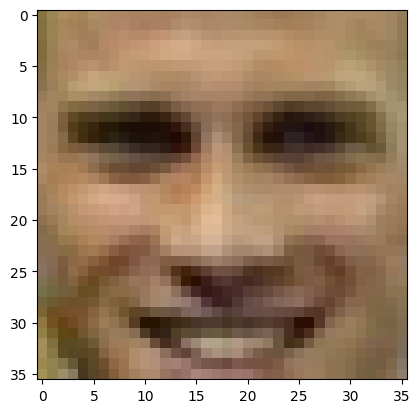

In [14]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces

import keras
from keras.models import Sequential
from keras import layers as L

In [26]:
CODE_SIZE = 256

# Build Generator
generator = Sequential()
generator.add(layers.InputLayer([CODE_SIZE],name='noise'))
generator.add(layers.Dense(10*8*8, activation='elu'))

generator.add(layers.Reshape((8,8,10)))
generator.add(layers.Conv2DTranspose(64,kernel_size=(5,5),activation='elu'))
generator.add(layers.Conv2DTranspose(64,kernel_size=(5,5),activation='elu'))
generator.add(layers.UpSampling2D(size=(2,2)))
generator.add(layers.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(layers.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(layers.Conv2DTranspose(32,kernel_size=3,activation='elu'))

generator.add(layers.Conv2D(3,kernel_size=3,activation=None))

In [27]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

In [28]:
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))

#<build discriminator body>
discriminator.add(L.Conv2D(16,[2,2],padding='same',activation='relu'))
discriminator.add(L.Conv2D(32,[2,2],padding='same',activation='relu'))
discriminator.add(L.MaxPool2D())

discriminator.add(L.Conv2D(64,[2,2],padding='same',activation='relu'))
discriminator.add(L.Conv2D(128,[2,2],padding='same',activation='relu'))
discriminator.add(L.MaxPool2D())


discriminator.add(L.Flatten())
discriminator.add(L.Dense(256,activation='tanh'))
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))

In [30]:
# Compile models
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
# Create optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [35]:
# Assuming the necessary imports and model definitions are already done

# Define the noise and real data shapes
batch_size = 100  # Example batch size

# Training loop
def train_gan(epochs, batch_size):
  for epoch in range(50000):
      # Generate random noise
      noise = np.random.normal(0, 1, (batch_size, CODE_SIZE))
      # Sample real data
      idx = np.random.randint(0, data.shape[0], batch_size)
      real_data = data[idx]

      ########################
      # Discriminator training #
      ########################
      with tf.GradientTape() as tape:
          logp_real = discriminator(real_data)
          generated_data = generator(noise)
          logp_gen = discriminator(generated_data)

          # Calculate discriminator loss
          d_loss = -tf.reduce_mean(logp_real) + tf.reduce_mean(logp_gen)

          # Regularization (if needed)
          d_loss += tf.reduce_mean(discriminator.layers[-1].kernel ** 2)

      # Calculate gradients and update discriminator
      grads = tape.gradient(d_loss, discriminator.trainable_variables)
      discriminator.optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

      ########################
      # Generator training #
      ########################
      with tf.GradientTape() as tape:
          generated_data = generator(noise)
          logp_gen = discriminator(generated_data)

          # Calculate generator loss
          g_loss = -tf.reduce_mean(logp_gen)

      # Calculate gradients and update generator
      grads = tape.gradient(g_loss, generator.trainable_variables)
      generator.optimizer.apply_gradients(zip(grads, generator.trainable_variables))
      grads = tape.gradient(g_loss, generator.trainable_variables)
      generator_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

      # Print progress
      if epoch % 1000 == 0:
          print(f'Epoch: {epoch}, D Loss: {d_loss.numpy()}, G Loss: {g_loss.numpy()}')

In [37]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

In [44]:
from IPython import display

for epoch in tqdm_utils.tqdm_notebook_failsafe(range(50000)):

    # Generate random noise and sample real data
    noise = sample_noise_batch(100)
    real_data = sample_data_batch(100)

# Train the discriminator multiple times
for i in range(5):
    with tf.GradientTape() as tape:
        logp_real = discriminator(real_data)
        generated_data = generator(noise)
        logp_gen = discriminator(generated_data)

        # Calculate discriminator loss
        d_loss = -tf.reduce_mean(tf.math.log(logp_real) + tf.math.log(1 - logp_gen))

    # Calculate gradients and update discriminator
    grads = tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

# Train the generator
with tf.GradientTape() as tape:
    generated_data = generator(noise)
    logp_gen = discriminator(generated_data)

    # Calculate generator loss
    g_loss = -tf.reduce_mean(tf.math.log(logp_gen))

# Calculate gradients and update generator
grads = tape.gradient(g_loss, generator.trainable_variables)
generator_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

if epoch %100==0:
    display.clear_output(wait=True)
    sample_images(2,3,True)
    sample_probas(1000)

**************************************************



In [48]:
#from submit_honor import submit_honor
#submit_honor((generator, discriminator), '<gauravtemp123@gmail.com>', '<token>')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


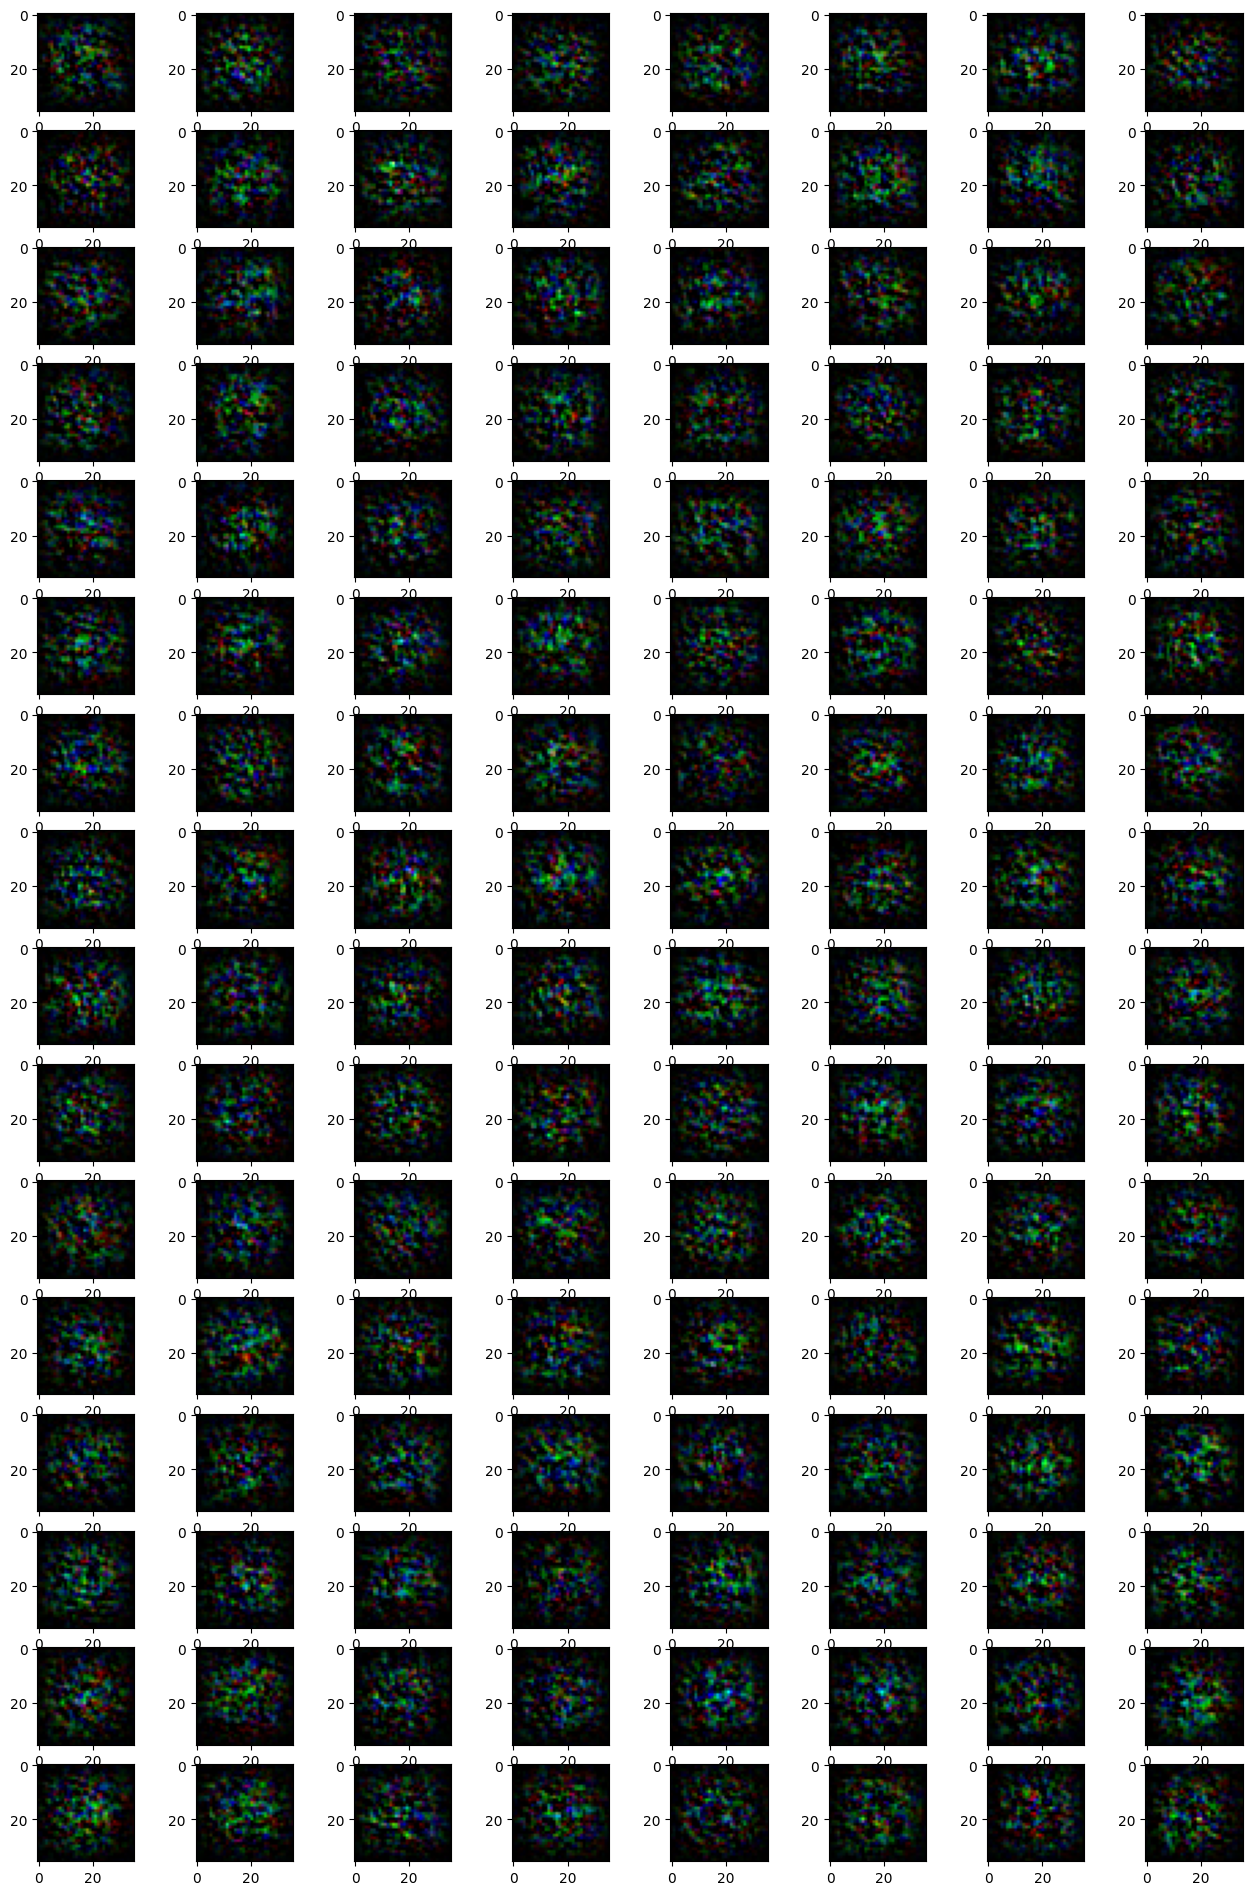

In [49]:
#The network was trained for about 15k iterations.
#Training for longer yields MUCH better results
plt.figure(figsize=[16,24])
sample_images(16,8)